In [2]:
'''GAN'''

#Import necessery packages

try:
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.autograd import Variable
    from matplotlib import pyplot as plt
except ImportError:
    print("Packages could not be imported")
    matplotlib_is_available = False



In [58]:
#Set the function parameters and other data
data_mean = 4
data_stddev = 1.25

g_input_size = 1      # Random noise dimension coming into generator, per output vector
g_hidden_size = 5     # Generator complexity
g_output_size = 1     # Size of generated output vector
d_input_size = 500    # Minibatch size - cardinality of distributions
d_hidden_size = 10    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification

minibatch_size = d_input_size



\begin{align}
\text{standard deviation} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \overline{x})^2} \newline
\text{var} = \frac{1}{N} \sum_{i=1}^N (\text{diffs})^2 \newline
\text{std = stamdard deviation} = \sqrt{\frac{1}{N} \sum_{i=1}^N (\text{diffs})^2} \newline
\text{zscores} = \frac{\text{diffs}}{\text{std}} \newline
\text{skews} = \frac{\sum_{i=1}^N \text{zscores}_i^3}{N} \newline
kurtoses = mean(zscores^4)-3 \newline
\text{final} = (mean value, standard deviation, skews, kurtoses)
\end{align}
 
 zscores is how much each datapoint differs from the standard deviation.
 
 Skews is the mean difference raised by 3 (for some reason, probbably just a working number).
 
 Kurtoses is the mean difference raised by 4 and subtracted with 3. 
 
Skews and kurtoses could can be compared with the loss of the input data.
 
 Theese numbers are saved in an list "final".

In [61]:
#Define preprocess function 

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean #Calculate difference between each value and the mean of the values
    var = torch.mean(torch.pow(diffs, 2.0)) #torch.pow(diffs, 2.0) is same as diff**2 for every element
    std = torch.pow(var, 0.5) 
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final



### Select preprocess to be get_moments(d) and discriminator input function to be x=4

(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)



tensor([3.8909, 1.2413, 0.1579, 0.1176])


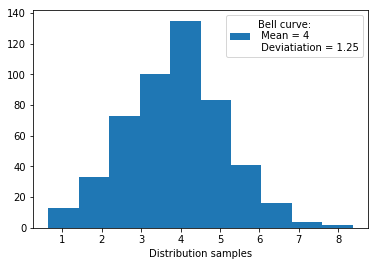

In [70]:
# ##### Provide accurate data from the distributionfunction

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

dist_func = get_distribution_sampler(data_mean, data_stddev)


dist_real_data = dist_func(d_input_size)

print(preprocess(dist_real_data))

plt.hist(dist_real_data)
plt.xlabel("Distribution samples")
plt.legend(['Bell curve: \n Mean = 4 \n Deviatiation = 1.25'], loc='best')
plt.show()

In [33]:
'''Construct class Generator'''

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):  #Input generator input size, generator complexity 
        super(Generator, self).__init__()                     #Output size and torch.tanh function (1 dimension in input and output)
        self.map1 = nn.Linear(input_size, hidden_size) #The sizes are the weigths and biases
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f
        '''Applies a linear transformation to the incoming data: y = xA^T + b
        Parameters:	
        in_features – size of each input sample
        out_features – size of each output sample'''
    def forward(self, x):   #Calculating size of inpput, hidden and output - layers. Using forward propegation
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x
    
        #Explination of input/output from nn.Linear method
        '''Input: (N, *, in_features) where * means any number of additional dimensions
            Output: (N, *, out_features) where all but the last dimension are the same shape as the input.'''
        
        '''Futher explination about the torch.nn.Linear'''
        '''https://pytorch.org/docs/stable/nn.html#linear'''

In [34]:
'''Construct class Discriminator'''
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

In [35]:
#Define activationfunctions
discriminator_activation_function = torch.sigmoid  #Standard sigmoid activation function
generator_activation_function = torch.tanh    #Returns a new tensor with the hyperbolic tangent of the elements of input

#Function to extract values from generated fake data
def extract(v):
    return v.data.storage().tolist()

#Function to return the mean and standard deviation
def stats(d):
    return [np.mean(d), np.std(d)]



tensor([-0.1501,  0.0616,  0.0176, -1.2304], grad_fn=<CatBackward>)
Without any training system believe the mean is:-0.1501 and standard deviation is: 0.0616


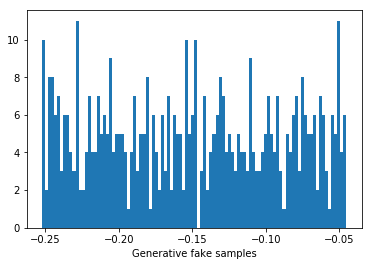

In [72]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Random numbers between 0 and 1 in a m x n matrix.

gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)

gen_input = Variable(gi_sampler(minibatch_size, g_input_size))

g_fake_data = G(gen_input)

values = extract(g_fake_data)

mean, standard = stats(values)

print(preprocess(g_fake_data))

print("Without any training system believe the mean is:{:.4f} and standard deviation is: {:.4f}".format(mean, standard))

plt.hist(values, bins=100)
plt.xlabel("Generative fake samples")
plt.show()

In [73]:
'''Define discriminator'''
D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
#Have the same starting sizes, weigths and biases as the generator but a sigmoid function instead

In [77]:
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
#Costfunction from pytorch

In [78]:
'''Compute error of generated model'''

dg_fake_decision = D(preprocess(g_fake_data.t()))  #Returns 4 first moments
print(dg_fake_decision)
g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine


tensor([0.4836], grad_fn=<SigmoidBackward>)


C:\Users\Jonatan Nordh\AppData\Local\conda\conda\envs\python36\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
